# GenVeg Main Script
GenVeg is a generalized vegetation growth model that simulates growth due to
photosynthesis as well as processes that control vegetation distribution such
as mortality, senescence, dispersal, and colonization. The model utilizes a 
mixture of existing and new landlab components to setup the model, simulates
relevant vegetation community dynamics with the local environment, and analyzes
results of the simulation. 

## Main model control set up
### Import components

In [1]:
import numpy as np, pandas as pd
import os, tempfile
from pathlib import Path
from datetime import date
from matplotlib.pyplot import title, show, figure, plot, subplot, xlabel, ylabel
from landlab import RasterModelGrid, imshow_grid, load_params
from landlab.data_record import DataRecord
from landlab.components.genveg import VegParams, PlantGrowth
from landlab.io.netcdf import write_netcdf

### Define time controls

In [2]:
sim_start_date = date(2010,1,1)
tot_sim_len_y = 30
veg_time_step_d = 1
env_time_step_d = 1

### Define filenames for input files
##### *Note should be located in same folder as this .ipynb

In [3]:
VegInputFile = 'GenVeg_params_inputs_1col.xlsx'

### Read in parameter and data input files
Identify model processes to be included so all required parameters are defined and calculated

In [4]:
inp_file=Path(VegInputFile).absolute()
VegParams(fpath=inp_file,processes=['plantsize','dispersal','colonization','storage'])
#VegParams(processes=['plantsize','dispersal','colonization','storage','mortality'])
vegparams=load_params('veg_params.yml')
print(vegparams)


{'BIS': {'growparams': {'glucose_requirement': [1.444, 1.513, 1.463], 'growing_season_end': 305, 'growing_season_start': 45, 'k_light_extinct': 0.02, 'light_half_sat': 9, 'p_max': 0.055, 'plant_part_min': [0.01, 0.1, 0.5], 'root_to_leaf_coeffs': [0.09, 0.889, -0.0254], 'root_to_stem_coeffs': [-0.097, 1.071, 0.0179], 'senescence_start': 228}, 'plant_factors': {'angio_gymno': 'angiosperm', 'annual_perennial': 'perennial', 'growth_form': 'shrub', 'monocot_dicot': 'monocot', 'ptype': 'C3', 'species': 'Burial intolerant stabilizer '}, 'sizeparams': {'max_height_stem': 1.0, 'max_n_stems': 3.0, 'max_plant_density': 34.0, 'total_cs_area_stems': 0.231}, 'storparams': {'wint_dieoff_roots': 0.25}}, 'BTS': {'growparams': {'glucose_requirement': [1.444, 1.513, 1.463], 'growing_season_end': 305, 'growing_season_start': 45, 'k_light_extinct': 0.02, 'light_half_sat': 9, 'p_max': 0.055, 'plant_part_min': [0.01, 0.1, 0.5], 'root_to_leaf_coeffs': [-0.107, 1.098, 0.0216], 'senescence_start': 228}, 'plant_

In [5]:
##Test block
for item in vegparams:
    growdict=vegparams[item]['growparams']
    end=growdict['growing_season_end']
    begin=growdict['growing_season_start']
    senes=growdict['senescence_start']
    if (begin > 0) & (begin < 366) & (end > 0) & (end < 366) & (end > begin) & (senes > begin) & (senes < end):
        length=end-begin+1
        print(length)
    


261
261
261


### Set up model grid using landlab RasterModelGrid functions

- Create the model grid
- Initialize live vegetation biomass and plant functional type
- Initialize the air temperature driver across the grid

##### **Note variable names should be consistent with landlab standards

In [6]:
#Create grid
pg = RasterModelGrid((100, 100), 2.0)
pg.axis_units = ('m', 'm')

#Initialize plant functional type as grass or bare
_ = pg.add_field('vegetation__plant_species',np.random.choice([0,2],pg.number_of_cells), at='cell')

#Initialize biomass to random quantity between 0 and 200 g/m^2
_ = pg.add_field('vegetation__live_biomass',np.where(pg.at_cell['vegetation__plant_species'] != 0,1,0)*
                np.random.uniform(low=0, high=200,size=pg.number_of_cells),at='cell', units='g')
_ = pg.add_field('vegetation__n_plants', np.where(pg.at_cell['vegetation__plant_species'] != 0,1,0)*
                np.random.choice([1,2,3],pg.number_of_cells), at='cell')
#Initialize with a random mean air temperture 
_ = pg.add_field('air__temperature_C', np.random.uniform(low=12, high=14,size=pg.number_of_cells), at='cell', units='C' )
_ = pg.add_field('radiation__net_flux', np.random.uniform(low=0, high=180, size=pg.number_of_cells), at='cell', units='W/m^2')



In [7]:
Tbio=pg["cell"]["vegetation__live_biomass"][:].copy()
root=np.zeros_like(Tbio)
leaf=np.zeros_like(Tbio)
stem=np.zeros_like(Tbio)
root_all=np.zeros_like(Tbio)
leaf_all=np.zeros_like(Tbio)
stem_all=np.zeros_like(Tbio)
rowind=0
print(len(Tbio))
for row in Tbio:
    #initialize row variables
    colind=0
    rootrow=np.empty([])
    leafrow=np.empty([])
    stemrow=np.empty([])


9604


### Plot grid with plant distribution and initial biomass

Use RasterModelGrid plot functions to visualize initial model grid

#### Vegetation type 
- 0=Bare
- 1=Annual
- 2=Herbaceous Perennial 
- 3=Woody Perennial

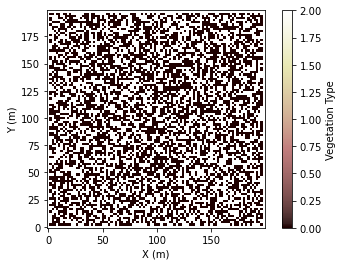

In [8]:
imshow_grid(pg, 'vegetation__plant_species', at='cell',colorbar_label='Vegetation Type')
show()

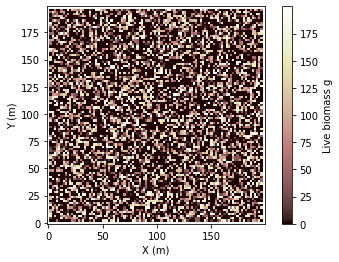

In [9]:
imshow_grid(pg, 'vegetation__live_biomass', at='cell', colorbar_label='Live biomass g')
show()

### Define model time variables
Determine basic model timestep and counter for model loop

In [10]:
sim_end = date(sim_start_date.year+tot_sim_len_y,sim_start_date.month,sim_start_date.day)
dt = min([veg_time_step_d,env_time_step_d])
#data['dt']=dt
day_freq = str(dt)+'D'
date_counter = pd.date_range(start=sim_start_date,end=sim_end,freq=day_freq).strftime('%Y-%m-%d').tolist()
step_counter=range(len(date_counter))
model_counter=tuple(zip(step_counter,date_counter))

Initialize crops PlantGrowth class with veg_params from Excel file

In [11]:
crops=PlantGrowth(pg,vegparams,dt) #need to update this to reflect changes in init key

d:\python\landlab\landlab\components\genveg\growth.py:180: RuntimeWarning: invalid value encountered in true_divide
  self._last_twg = self._last_veg_biomass/self._last_veg_n_plant


IndexError: index 1 is out of bounds for axis 0 with size 1

## Main model loop script
This is the main model loop that controls the simulation that
- Advances model time 
- Updates environmental variables
- Simulates changes to vegetation communities
- Stores outputs

In [ ]:
for i in model_counter:
    #update temp attirbute on grid
    crops.run_one_step()
    #if this is a save timestep, save grid object to netcdf

In [ ]:
temp_dir = tempfile.mkdtemp()
os.chdir(temp_dir)
write_netcdf("test.nc", pg, format="NETCDF3_64BIT", time=step_counter[0])